In [1]:
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import bcubed
from sklearn.decomposition import PCA

As first step we read the dataset and reading the first 5 raw to make sure that reading done good

In [2]:
df = pd.read_csv("final_dataset.csv")
df.head()

,label,text
0,anger,grab minute post feel greedy wrong
1,anger,feel grouchy
2,anger,think easiest time year feel dissatisfy
3,anger,feel irritate reject without anyone anything s...
4,anger,already feel like fuck though usually eat morning


we now removing the leabel to start the unsupervised learning process

In [3]:
texts = df["text"]
texts.head()

0                   grab minute post feel greedy wrong
1                                         feel grouchy
2              think easiest time year feel dissatisfy
3    feel irritate reject without anyone anything s...
4    already feel like fuck though usually eat morning
Name: text, dtype: object

make text appers in numric representation

In [4]:
vectorizer = TfidfVectorizer(ngram_range=(1,2) )
tfidf = vectorizer.fit_transform(texts)
tfidf.shape

(10414, 69708)

To determine the right number of clusters in K-means we use the Elbow method that give a pairs of (number of clusters,WCSS-Within-Cluster Sum of Squares)
we choose the point that adding more clusters no longer provides a significant reduction in WCSS(Elbow point)

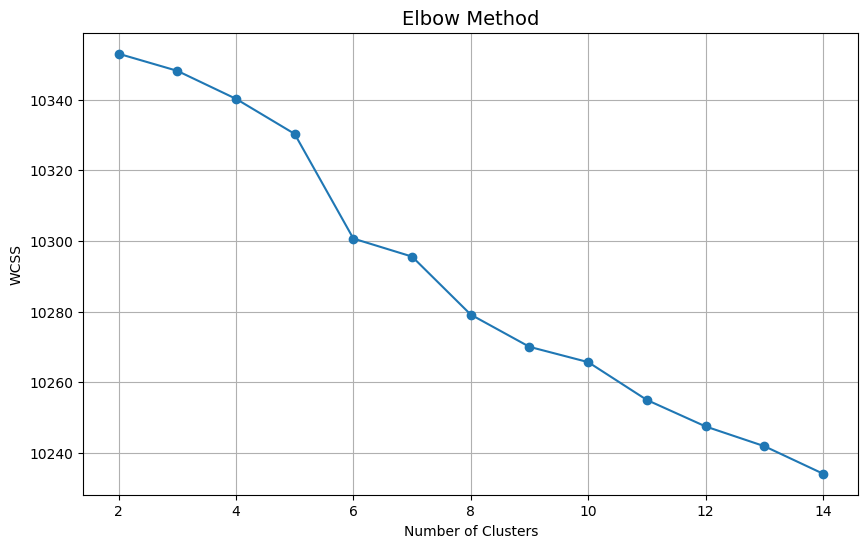

In [5]:
wcss = []
for k in range(2, 15):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(tfidf)
    wcss.append(km.inertia_) 
plt.figure(figsize=(10,6))
plt.plot(range(2, 15), wcss, marker='o')
plt.title("Elbow Method", fontsize=14)
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()

we decided that k=8 is the elbow method

In [7]:
finalkmean = KMeans(n_clusters=8, random_state=42)
Clabels = finalkmean.fit_predict(tfidf)
print("WCSS:",finalkmean.inertia_)

WCSS: 10279.14755656348


In [8]:
score = silhouette_score(tfidf, Clabels)
print("Silhouette Score:",score)

Silhouette Score: 0.002921665809247608


This value is almost zero, which typically indicates poor clustering.
However, in our case it is acceptable because after vectorization the data reached a dimensionality of d = 69,708, which makes distance-based measures extremely unreliable and naturally pushes the Silhouette score toward zero, also known as the Curse of Dimensionality [1].

now we will have the real labels -ground truth- to calculate the Precision,Recall and F-score

In [9]:
labels=df['label']
labels.head()

0    anger
1    anger
2    anger
3    anger
4    anger
Name: label, dtype: object

In [10]:
ldict = {i: set([labels[i]]) for i in range(len(labels))}
cdict = {i: set([Clabels[i]]) for i in range(len(Clabels))}
print(f"8-means Precision: {bcubed.precision(cdict, ldict)*100:.2f}")
print(f"8-means Recall: {bcubed.recall(cdict, ldict)*100:.2f}")
print(f"8-means F-Score: {bcubed.recall(cdict, ldict)*100:.2f}")

8-means Precision: 21.74
8-means Recall: 36.84
8-means F-Score: 36.84


After analyzing these results, we noticed that the clustering was able to capture the overall groups correctly (high recall), but it couldn’t keep each cluster clean and pure (low precision). This behavior is normal in text data, especially when the dimensionality is extremely high. The F-score summarizes both precision and recall together, giving a clearer overall measure of the clustering performance.

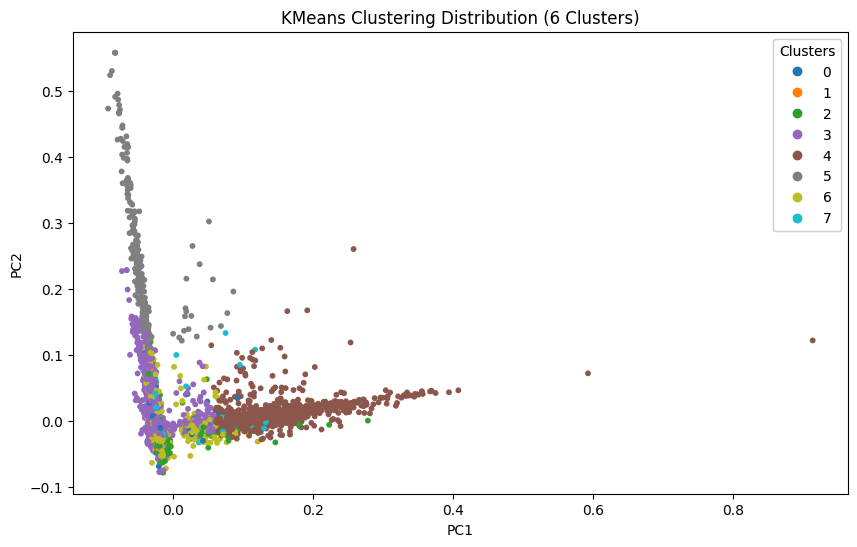

In [11]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(tfidf.toarray())
plt.figure(figsize=(10,6))
scatter = plt.scatter(x_pca[:,0], x_pca[:,1],c=Clabels,cmap='tab10', s=10)
plt.title("KMeans Clustering Distribution (6 Clusters)")
plt.xlabel("PC1")
plt.ylabel("PC2")
legend = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend)
plt.show()

we reducing the dimensionality to visualize the clustering, we noticed that there is overlap and no clear separation between the clusters.

Here we try to enhance the clustering by improving the vectorization process. We use SentenceTransformer, which maps each sentence into a numerical vector based on its meaning and produces a fixed-size embedding of 384 dimensions.

In [12]:
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(texts, show_progress_bar=True)
print("Embeddings Shape:", embeddings.shape)

Batches:   0%|          | 0/326 [00:00<?, ?it/s]

Embeddings Shape: (10414, 384)


Instead of K-means, we used Hierarchical Clustering — specifically Agglomerative Clustering — which starts with each point as its own cluster and keeps merging them step-by-step until reaching the specified number of clusters (n = 2 in our case).

In [13]:
agg = AgglomerativeClustering(n_clusters=2,metric='cosine',linkage='average')
agg_labels = agg.fit_predict(embeddings)

In [14]:
silhouette = silhouette_score(embeddings, agg_labels, metric='cosine')
print("Silhouette Score:", silhouette)

Silhouette Score: 0.19715726375579834


we noticed that it has higher Silhouette score by factor 100!

In [15]:
ldict = {i: set([labels[i]]) for i in range(len(labels))}
cdict = {i: set([agg_labels[i]]) for i in range(len(agg_labels))}
print(f"Agg Precision: {bcubed.precision(cdict, ldict)*100:.2f}")
print(f"Agg Recall: {bcubed.recall(cdict, ldict)*100:.2f}")
print(f"Agg F-Score: {bcubed.recall(cdict, ldict)*100:.2f}")

Agg Precision: 20.99
Agg Recall: 99.92
Agg F-Score: 99.92


With almost perfect recall, there is a slight reduction in precision. However, we can say that Hierarchical Clustering performs better than K-Means overall.

Integration & Insight:
After applying two clustering methods, the results never gave a clear separation. Even though the recall was high, the other metrics made it difficult for us to use these clusters to enhance the supervised learning model. This is expected, since the emotions need to be separated based on semantic meaning, and the clustering methods -we used and studied- were not able to capture that level of separation.

Refrence:
[1]Škrlj, T., Vrečko, A., & Rupnik, R. “Clustering Evaluation in High-Dimensional Data.”
2015 4th International Conference on Data Science and Advanced Analytics (DSAA),
pp. 1–10, 2015.